<a href="https://colab.research.google.com/github/umerkay/satellite-imaging-segmentation/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

# Data

In [2]:
DATA_URL = 'https://www.kaggle.com/datasets/geoap96/deepglobe2018-landcover-segmentation-traindataset'
!pip install opendatasets --upgrade --quiet
import opendatasets as od
od.download(DATA_URL)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: umerkay
Your Kaggle Key: ··········


100%|██████████| 1.93G/1.93G [00:19<00:00, 108MB/s]


In [3]:
import zipfile
with zipfile.ZipFile("/content/deepglobe2018-landcover-segmentation-traindataset/data.zip", 'r') as zip_ref:
  zip_ref.extractall("/content/data")

In [4]:
DATA_DIR = '/content/data/data'

VAL_DIR = DATA_DIR + '/test_data'
TRAIN_DIR = DATA_DIR + '/training_data'

Image Size (2448, 2448, 3)
Mask Size (2448, 2448, 3)


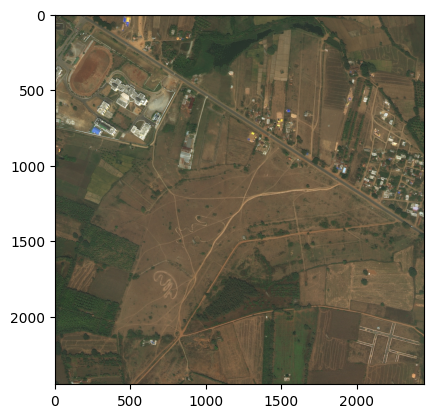

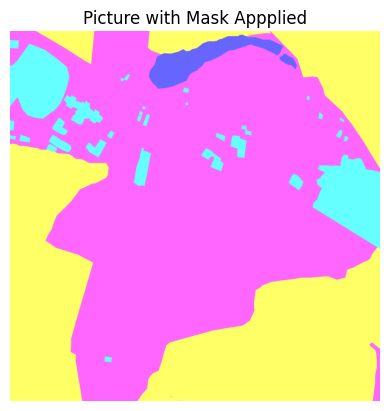

In [5]:
img = Image.open(TRAIN_DIR + '/images/235869_sat.jpg')
mask = Image.open(TRAIN_DIR + '/masks/235869_mask.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img, cmap = 'viridis')
plt.show()
msk = plt.imshow(mask, alpha=0.6, cmap ='viridis')
plt.title('Picture with Mask Appplied')
plt.axis('off')

# Show the plot
plt.show()

In [129]:
# from torchvision import transforms as T
# import cv2

# class SatDataSet(Dataset):

#     def __init__(self, path, mean, std, transform=None):
#         self.img_path = path + "/images"
#         self.mask_path = path + "/masks"

#         name = []
#         for dirname, _, filenames in os.walk(self.img_path):
#             for filename in filenames:
#                 name.append(filename.split('_')[0])

#         self.X = pd.DataFrame({'id': name}, index = np.arange(0, len(name))).values
#         print("Number of images found: ", len(self.X))

#         self.transform = transform
#         self.mean = mean
#         self.std = std

#     @classmethod
#     def preprocess(cls, pil_img):
#         # w, h = pil_img.size
#         # newW, newH = int(scale * w), int(scale * h)
#         # assert newW > 0 and newH > 0, 'Scale is too small'
#         # pil_img = pil_img.resize((newW, newH))

#         img_nd = np.array(pil_img)

#         # if len(img_nd.shape) == 2:
#             # img_nd = np.expand_dims(img_nd, axis=2)

#         # HWC to CHW
#         img_trans = img_nd.transpose((2, 0, 1))
#         # if img_trans.max() > 1:
#             # img_trans = img_trans / 255
#         return img_trans

#     def preprocess_mask(cls, pil_img):
#         # w, h = pil_img.size
#         # newW, newH = int(scale * w), int(scale * h)
#         # assert newW > 0 and newH > 0, 'Scale is too small'
#         # pil_img = pil_img.resize((newW, newH))

#         img_nd = np.array(pil_img)

#         # if len(img_nd.shape) == 2:
#             # img_nd = np.expand_dims(img_nd, axis=2)

#         # HWC to CHW
#         img_trans = img_nd.transpose((2, 0, 1))
#         # torch.set_printoptions(edgeitems=10)
#         return img_trans

#     def RGB_2_class_idx(cls, mask_to_be_converted):
#         mapping = {(0  , 255, 255): 0,     #urban_land
#                    (255, 255, 0  ): 1,    #agriculture
#                    (255, 0  , 255): 2,    #rangeland
#                    (0  , 255, 0  ): 3,      #forest_land
#                    (0  , 0  , 255): 4,      #water
#                    (255, 255, 255):5,     #barren_land
#                    (0  , 0  , 0  ):6}           #unknown

#         # mapping = {(0.,1., 1.): 0,     #urban_land
#         #         (1., 1., 0.): 1,    #agriculture
#         #         (1., 0., 1.): 2,    #rangeland
#         #         (0., 1., 0.): 3,      #forest_land
#         #         (0., 0., 1.): 4,      #water
#         #         (1.,1.,1.):5,     #barren_land
#         #         (0.,0.,0.):6}           #unknown
#         temp = np.array(mask_to_be_converted)
#         temp = np.where(temp>=128, 255, 0)

#         class_mask=torch.from_numpy(temp)
#         h, w = class_mask.shape[1], class_mask.shape[2]
#         mask_out = torch.zeros(h, w, dtype=torch.long)
#         for k in mapping:
#             idx = (class_mask == torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
#             validx = (idx.sum(0) == 3)
#             mask_out[validx] = torch.tensor(mapping[k], dtype=torch.long)

#         return mask_out

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         img = cv2.imread(self.img_path + "/" + self.X[idx][0] + '_sat.jpg')
#         # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         # mask = cv2.imread(self.mask_path + "/" + self.X[idx][0] + '_mask.png', cv2.IMREAD_GRAYSCALE)
#         mask = cv2.imread(self.mask_path + "/" + self.X[idx][0] + '_mask.png')

#         if self.transform is not None:
#             aug = self.transform(image=img, mask=mask)
#             img = Image.fromarray(aug['image'])
#             mask = aug['mask']

#         mask_img = mask

#         if self.transform is None:
#             img = Image.fromarray(img)
#             # mask = Image.fromarray(mask)

#         # t = T.Normalize(self.mean, self.std)
#         t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
#         img = t(img)
#         # mask = torch.from_numpy(mask).long()

#         # img = self.preprocess(img)
#         # mask = self.preprocess_mask(mask)
#         # img = img.permute(2,0,1)
#         mask = mask.transpose(2,0,1)
#         mask = self.RGB_2_class_idx(mask)
#         return img.type(torch.FloatTensor), mask.type(torch.FloatTensor)
#         # return {
#         #     'image': torch.from_numpy(img).type(torch.FloatTensor),
#         #     # 'mask': torch.from_numpy(mask).type(torch.FloatTensor)
#         #     'mask': mask
#         # }

In [7]:
# from torchvision import transforms as T
# import cv2
# from glob import glob

# class SatDataSet(Dataset):

#     def __init__(self, path, mean, std, transform=None):
#         self.img_path = path + "/images"
#         self.mask_path = path + "/masks"

#         name = []
#         for dirname, _, filenames in os.walk(self.img_path):
#             for filename in filenames:
#                 name.append(filename.split('_')[0])

#         self.X = pd.DataFrame({'id': name}, index = np.arange(0, len(name))).values
#         print("Number of images found: ", len(self.X))

#         self.transform = transform
#         self.mean = mean
#         self.std = std
#         self.scale = 1

#     @classmethod
#     def preprocess(cls, pil_img, scale):
#         w, h = pil_img.size
#         newW, newH = int(scale * w), int(scale * h)
#         assert newW > 0 and newH > 0, 'Scale is too small'
#         pil_img = pil_img.resize((512,512))

#         img_nd = np.array(pil_img)

#         if len(img_nd.shape) == 2:
#             img_nd = np.expand_dims(img_nd, axis=2)

#         # HWC to CHW
#         img_trans = img_nd.transpose((2, 0, 1))
#         if img_trans.max() > 1:
#             img_trans = img_trans / 255
#         return img_trans

#     def preprocess_mask(cls, pil_img, scale):
#         w, h = pil_img.size
#         newW, newH = int(scale * w), int(scale * h)
#         assert newW > 0 and newH > 0, 'Scale is too small'
#         pil_img = pil_img.resize((512,512))

#         img_nd = np.array(pil_img)

#         if len(img_nd.shape) == 2:
#             img_nd = np.expand_dims(img_nd, axis=2)

#         # HWC to CHW
#         img_trans = img_nd.transpose((2, 0, 1))
#         torch.set_printoptions(edgeitems=10)
#         return img_trans

#     def __len__(self):
#         return len(self.X)

#     def RGB_2_class_idx(cls, mask_to_be_converted):
#         print(mask_to_be_converted.shape)
#         mapping = {(0  , 255, 255): 0,     #urban_land
#                    (255, 255, 0  ): 1,    #agriculture
#                    (255, 0  , 255): 2,    #rangeland
#                    (0  , 255, 0  ): 3,      #forest_land
#                    (0  , 0  , 255): 4,      #water
#                    (255, 255, 255):5,     #barren_land
#                    (0  , 0  , 0  ):6}           #unknown

#         # mapping = {(0.,1., 1.): 0,     #urban_land
#         #         (1., 1., 0.): 1,    #agriculture
#         #         (1., 0., 1.): 2,    #rangeland
#         #         (0., 1., 0.): 3,      #forest_land
#         #         (0., 0., 1.): 4,      #water
#         #         (1.,1.,1.):5,     #barren_land
#         #         (0.,0.,0.):6}           #unknown
#         temp = np.array(mask_to_be_converted)
#         temp = np.where(temp>=128, 255, 0)

#         class_mask=torch.from_numpy(temp)
#         h, w = class_mask.shape[1], class_mask.shape[2]
#         mask_out = torch.zeros(h, w, dtype=torch.long)
#         for k in mapping:
#             idx = (class_mask == torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
#             validx = (idx.sum(0) == 3)
#             mask_out[validx] = torch.tensor(mapping[k], dtype=torch.long)

#         return mask_out

#     def __getitem__(self, i):
#         # idx = self.ids[i]
#         # idx = idx[:len(idx) - 4]
#         idx = self.X[i][0]
#         mask_file = glob(self.mask_path + "/" + idx + '_mask.png')
#         img_file = glob(self.img_path + "/" + idx + '_sat.jpg')

#         assert len(mask_file) == 1, \
#             f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
#         assert len(img_file) == 1, \
#             f'Either no image or multiple images found for the ID {idx}: {img_file}'
#         mask = Image.open(mask_file[0])
#         img = Image.open(img_file[0])

#         assert img.size == mask.size, \
#             f'Image and mask {idx} should be the same size, but are {img.size} and {mask.size}'

#         img = self.preprocess(img, self.scale)
#         mask = self.preprocess_mask(mask, self.scale)
#         mask = self.RGB_2_class_idx(mask)
#         return {
#             'image': torch.from_numpy(img).type(torch.FloatTensor),
#             # 'mask': torch.from_numpy(mask).type(torch.FloatTensor)
#             'mask': mask
#         }

In [6]:
from torchvision import transforms as T
import cv2
from glob import glob

class SatDataSet(Dataset):

    def __init__(self, path, mean, std, transform=None):
        self.img_path = path + "/images"
        self.mask_path = path + "/masks"

        name = []
        for dirname, _, filenames in os.walk(self.img_path):
            for filename in filenames:
                name.append(filename.split('_')[0])

        self.X = pd.DataFrame({'id': name}, index = np.arange(0, len(name))).values
        print("Number of images found: ", len(self.X))

        self.transform = transform
        self.mean = mean
        self.std = std
        self.mapping = {(0, 255, 255): 0,     #urban_land
                (255, 255, 0): 1,    #agriculture
                (255, 0, 255): 2,    #rangeland
                (0, 255, 0): 3,      #forest_land
                (0, 0, 255): 4,      #water
                (255, 255, 255): 5,  #barren_land
                (0, 0, 0): 6}        #unknown

    def __len__(self):
        return len(self.X)

    # def RGB_2_class_idx(cls, mask_to_be_converted):
    #     mapping = {(0  , 255, 255): 0,     #urban_land
    #                (255, 255, 0  ): 1,    #agriculture
    #                (255, 0  , 255): 2,    #rangeland
    #                (0  , 255, 0  ): 3,      #forest_land
    #                (0  , 0  , 255): 4,      #water
    #                (255, 255, 255):5,     #barren_land
    #                (0  , 0  , 0  ):6}           #unknown

    #     temp = np.array(mask_to_be_converted)
    #     temp = np.where(temp>=128, 255, 0)

    #     class_mask=torch.from_numpy(temp)
    #     h, w = class_mask.shape[1], class_mask.shape[2]
    #     mask_out = torch.zeros(h, w, dtype=torch.long)
    #     for k in mapping:
    #         idx = (class_mask == torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
    #         validx = (idx.sum(0) == 3)
    #         mask_out[validx] = torch.tensor(mapping[k], dtype=torch.long)

    #     return mask_out

    def RGB_2_class_idx(self, mask_to_be_converted):
      mapping = {(0, 255, 255): 0,     #urban_land
                (255, 255, 0): 1,    #agriculture
                (255, 0, 255): 2,    #rangeland
                (0, 255, 0): 3,      #forest_land
                (0, 0, 255): 4,      #water
                (255, 255, 255): 5,  #barren_land
                (0, 0, 0): 6}        #unknown
      temp = np.array(mask_to_be_converted)
      temp = np.where(temp>=128, 255, 0)

      class_mask=torch.from_numpy(temp)
      h, w = class_mask.shape[1], class_mask.shape[2]
      mask_out = torch.zeros(h, w, dtype=torch.long)
      for k in mapping:
          idx = (class_mask == torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
          validx = (idx.sum(0) == 3)
          mask_out[validx] = torch.tensor(mapping[k], dtype=torch.long)

      return mask_out

    def __getitem__(self, i):
        idx = self.X[i][0]


        img = cv2.imread(self.img_path + "/" + idx + '_sat.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + "/" + idx + '_mask.png')
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = self.RGB_2_class_idx(mask.transpose(2,0,1))
        return {
            'image': img.type(torch.FloatTensor),
            # 'mask': torch.from_numpy(mask).type(torch.FloatTensor)
            'mask': mask
        }

In [7]:
import albumentations as A

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)])

#datasets
train_set = SatDataSet(TRAIN_DIR, mean, std, t_train)
val_set = SatDataSet(VAL_DIR, mean, std, t_val)

#dataloader
batch_size= 8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

# class DeviceDataLoader():
#     """Wrap a dataloader to move data to a device"""
#     def __init__(self, dl, device):
#         self.dl = dl
#         self.device = device

#     def __iter__(self):
#         """Yield a batch of data after moving it to device"""
#         for b in self.dl:
#             yield to_device(b, self.device)

#     def __len__(self):
#         """Number of batches"""
#         return len(self.dl)

# train_dl = DeviceDataLoader(train_dl, device)
# valid_dl = DeviceDataLoader(valid_dl, device)

Number of images found:  683
Number of images found:  120


torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])


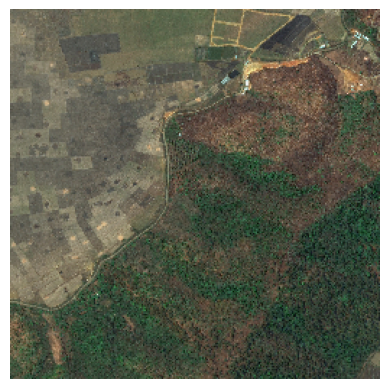

['urban', 'agro', 'rangeland', 'forest', 'water', 'barren', 'unknown']


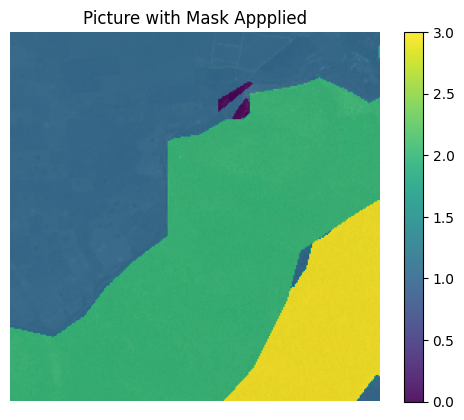

In [8]:
#get image from train loader and display the mask and img
data = next(iter(train_loader))
img = data['image']
mask = data['mask']
print(img.shape, mask.shape)

plt.axis('off')

plt.imshow(((img[0] * torch.tensor(std).view(3, 1, 1)) + torch.tensor(mean).view(3, 1, 1)).permute(1,2,0))
plt.show()
plt.axis('off')
plt.imshow(((img[0] * torch.tensor(std).view(3, 1, 1)) + torch.tensor(mean).view(3, 1, 1)).permute(1,2,0))
# print(mask)
msk = plt.imshow(mask[0], alpha=0.9)
plt.colorbar(msk)
print(['urban', 'agro', 'rangeland', 'forest', 'water', 'barren', 'unknown'])
plt.title('Picture with Mask Appplied')
# Show the plot
plt.show()

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
from tqdm import tqdm

def classcount(loader):
    n_train = len(loader)

    class_weight = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])

    with tqdm(total=n_train, desc='Class Count Assessment', unit='batch', disable = False, leave=True) as pbar:
        for batch in loader:
            imgs, true_masks = batch['image'], batch['mask']
            (unique, counts) = np.unique(true_masks, return_counts=True)
            frequencies = np.asarray((unique, counts))
            # print(frequencies.shape)
            for i in range(frequencies.shape[1]):
                class_weight[frequencies[0,i]] += frequencies[1,i]
            pbar.update()

    # print(class_weight)
    class_weight = class_weight[:-1].min()/class_weight
    class_weight[-1]=0

    return class_weight

weights_classes = torch.from_numpy(classcount(train_loader))
weights_classes = weights_classes.to(device=device, dtype=torch.float32) # if training is to be done on gpu

#usage
# criterion = nn.CrossEntropyLoss(weight = weights_classes)
# loss = criterion(masks_pred, true_masks)

#define model
#write training loop
#train

Class Count Assessment: 100%|██████████| 86/86 [02:04<00:00,  1.45s/batch]


In [30]:
weights_classes

tensor([0.3001, 0.0581, 0.4032, 0.3110, 1.0000, 0.4279, 0.0000],
       device='cuda:0')

In [31]:
!pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="mobilenet_v2",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=7,                      # model output channels (number of classes in your dataset)
    encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16]
)


In [ ]:
print(model)


In [64]:
data = next(iter(train_loader))
img = data['image']
mask = data['mask']

output = model(img.to(device))

In [51]:
output.shape

torch.Size([8, 7, 256, 256])

In [12]:
torch.argmax(F.softmax(output, dim=1), dim=1)

tensor([[[2, 2, 1,  ..., 2, 1, 4],
         [1, 1, 1,  ..., 1, 2, 2],
         [1, 2, 2,  ..., 3, 3, 2],
         ...,
         [2, 2, 2,  ..., 1, 3, 2],
         [2, 2, 2,  ..., 2, 3, 2],
         [4, 2, 2,  ..., 4, 2, 2]],

        [[2, 2, 2,  ..., 1, 5, 2],
         [2, 2, 2,  ..., 1, 1, 2],
         [3, 3, 3,  ..., 1, 5, 5],
         ...,
         [2, 2, 2,  ..., 1, 1, 3],
         [2, 2, 2,  ..., 1, 3, 2],
         [4, 2, 2,  ..., 4, 4, 4]],

        [[2, 1, 1,  ..., 1, 1, 4],
         [2, 2, 2,  ..., 1, 2, 1],
         [3, 2, 2,  ..., 1, 3, 1],
         ...,
         [1, 3, 3,  ..., 2, 3, 2],
         [1, 2, 2,  ..., 2, 3, 2],
         [4, 2, 2,  ..., 4, 2, 4]],

        ...,

        [[1, 2, 1,  ..., 1, 2, 4],
         [2, 1, 2,  ..., 1, 2, 2],
         [1, 1, 3,  ..., 3, 3, 2],
         ...,
         [2, 2, 2,  ..., 1, 1, 6],
         [2, 2, 2,  ..., 1, 3, 2],
         [4, 2, 2,  ..., 4, 4, 4]],

        [[2, 2, 2,  ..., 1, 3, 3],
         [6, 2, 2,  ..., 1, 3, 3],
         [6,

torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256]) torch.Size([8, 7, 256, 256])


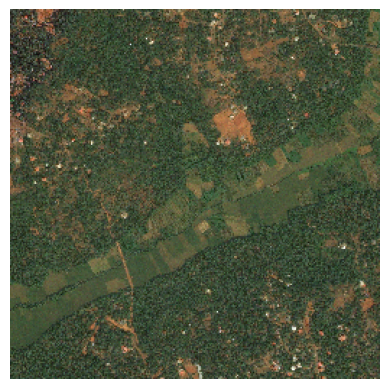

['urban', 'agro', 'rangeland', 'forest', 'water', 'barren', 'unknown']


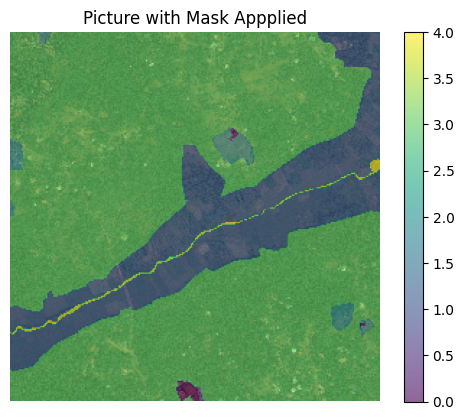

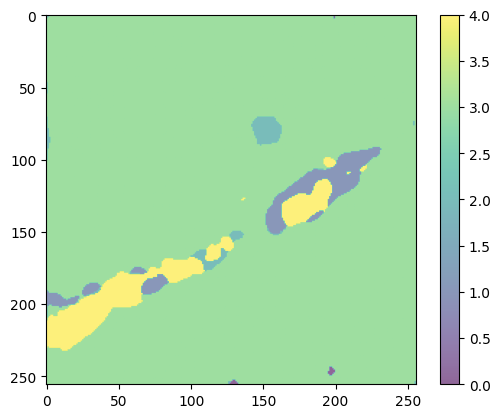

In [52]:
print(img.shape, mask.shape, output.shape)
predmask = torch.argmax(F.softmax(output, dim=1), dim=1)

plt.axis('off')
idx = 2
imgone = img[idx]
maskone = mask[idx]
predone = predmask[idx]

# plt.imshow(imgone.permute(1,2,0))
plt.imshow(((imgone * torch.tensor(std).view(3, 1, 1)) + torch.tensor(mean).view(3, 1, 1)).permute(1,2,0))

plt.show()
plt.axis('off')
plt.imshow(((imgone * torch.tensor(std).view(3, 1, 1)) + torch.tensor(mean).view(3, 1, 1)).permute(1,2,0))
# print(mask)
msk = plt.imshow(maskone, alpha=0.6)
plt.colorbar(msk)
print(['urban', 'agro', 'rangeland', 'forest', 'water', 'barren', 'unknown'])
plt.title('Picture with Mask Appplied')
# Show the plot
plt.show()
predone = predone.cpu()
msk = plt.imshow(predone, alpha=0.6)
plt.colorbar(msk)
plt.show()


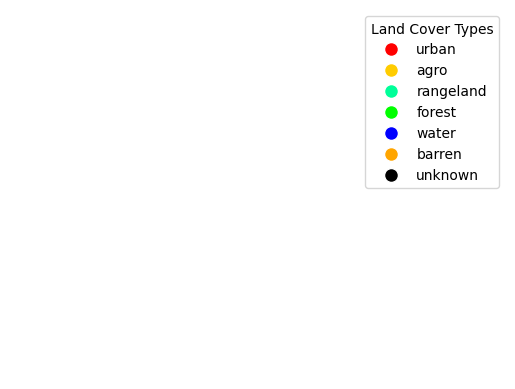

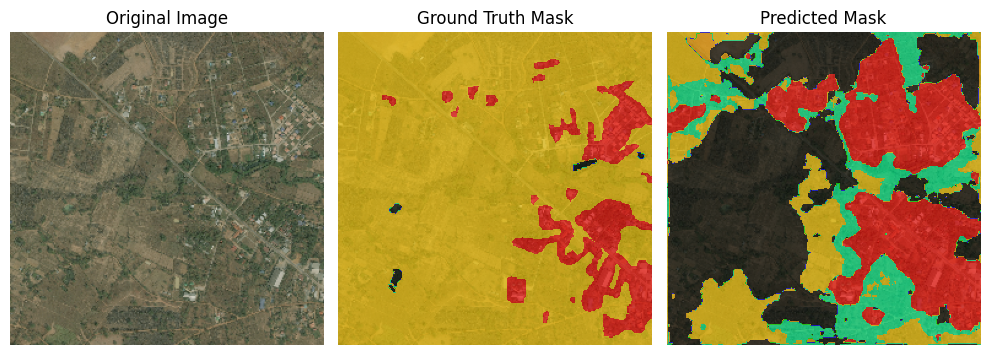

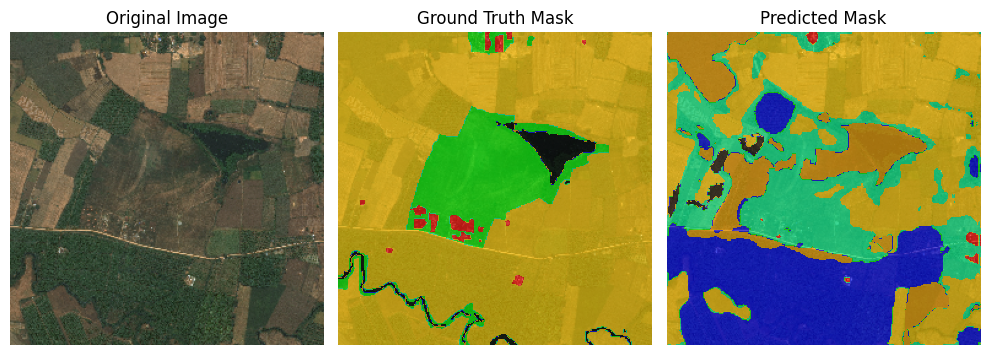

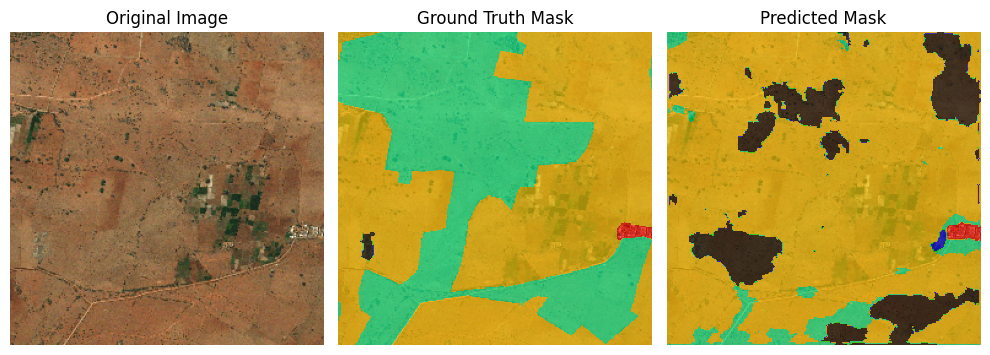

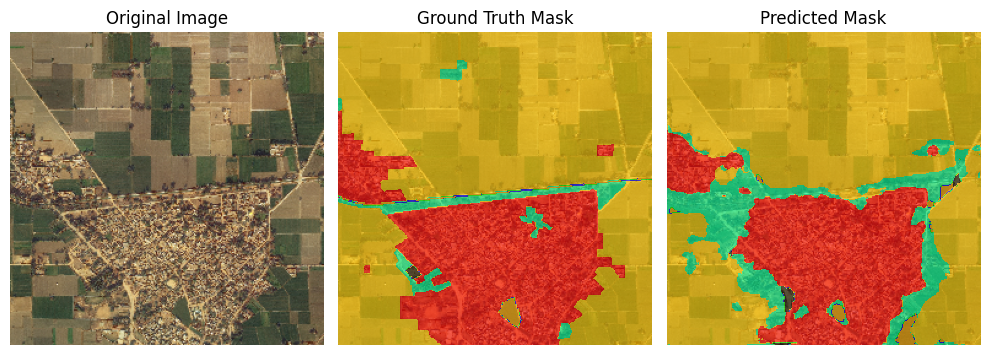

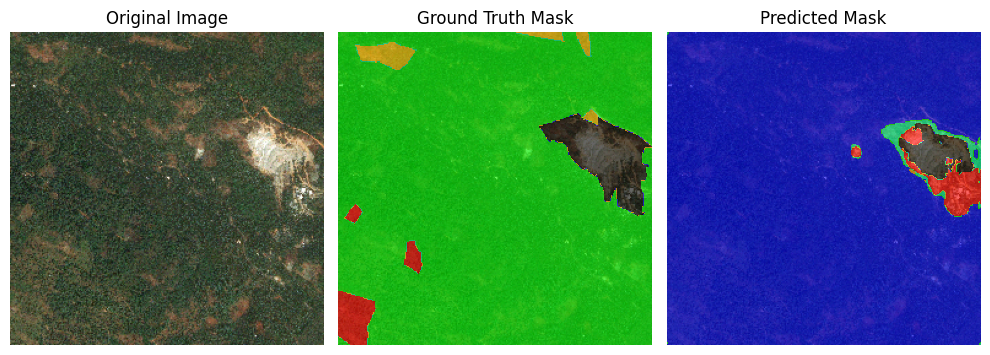

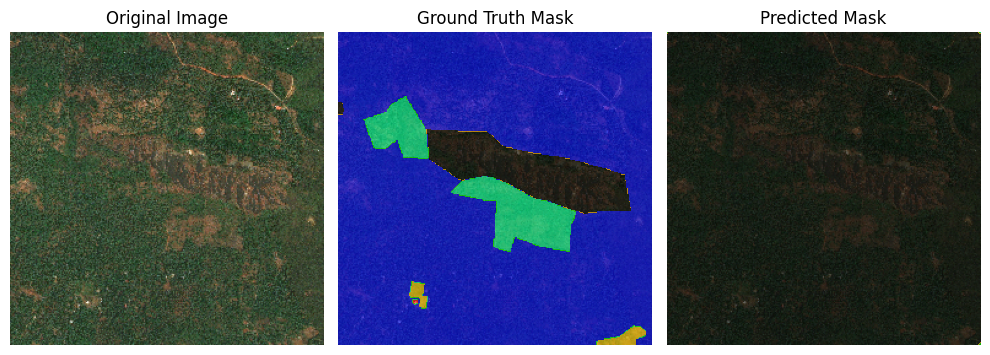

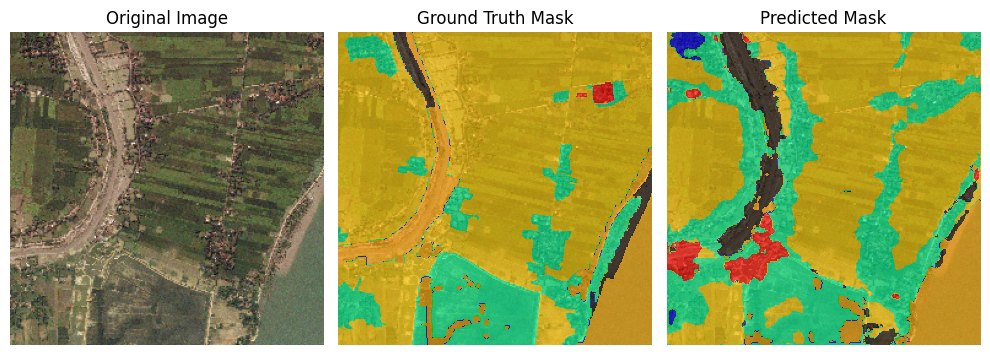

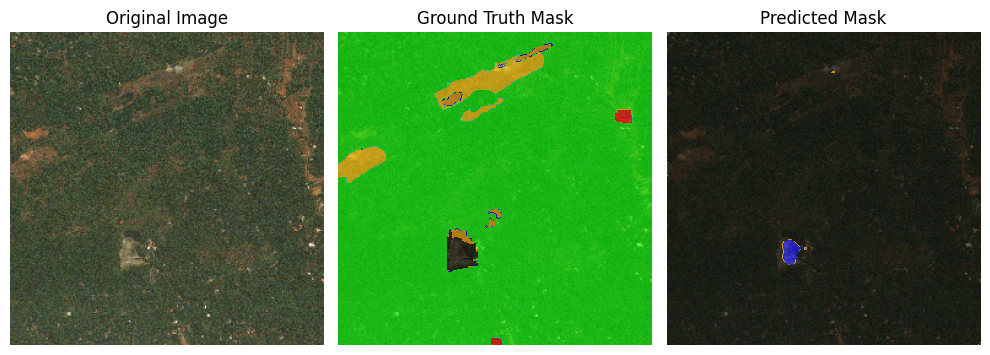

In [65]:
from matplotlib.colors import ListedColormap

# Calculate predicted mask
predmask = torch.argmax(output, dim=1)

# Plot settings
colors = ['#FF0000', '#FFCC00', '#00FF99', '#00FF00', '#0000FF', '#FFA500', '#000000']
colormap = ListedColormap(colors)
class_labels = ['urban', 'agro', 'rangeland', 'forest', 'water', 'barren', 'unknown']

alpha = 0.6
color_key = dict(zip(class_labels, colors))

# Create a legend using the color-key mapping
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_key[label], markersize=10, label=label) for label in class_labels]

plt.legend(handles=handles, title='Land Cover Types')
plt.axis('off')
plt.show()

# Display images with masks
for idx in range(8):
    imgone = img[idx]
    maskone = mask[idx]
    predone = predmask[idx]

    # Plot original image with unnormalized values
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    img_unnormalized = ((imgone * torch.tensor(std).view(3, 1, 1)) + torch.tensor(mean).view(3, 1, 1)).permute(1, 2, 0)
    plt.imshow(img_unnormalized)
    plt.axis('off')
    plt.title('Original Image')

    # Plot ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(img_unnormalized)
    plt.imshow(maskone, cmap=colormap, alpha=alpha)
    plt.axis('off')
    plt.title('Ground Truth Mask')

    # Plot predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(img_unnormalized)
    plt.imshow(predone.cpu(), cmap=colormap, alpha=alpha)
    plt.axis('off')
    plt.title('Predicted Mask')



    plt.tight_layout()
    plt.show()


In [35]:
# Calculate pixel accuracy over a batch of images
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [36]:
# Calculate mean Intersection-over-Union over a batch of images
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=5):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [37]:
# Inner loop for running the model for 1 epoch over a given loader

def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):

  if train:
    model.train()
  else:
    model.eval()


  total_correct_preds = 0

  total_loss = 0

  # Number of images we can get by the loader
  total_samples_in_loader = len(loader.dataset)

  # number of batches we can get by the loader
  total_batches_in_loader = len(loader)

  for batch in tqdm(loader):

    # Transfer image_batch to GPU if available
    image_batch = batch['image'].to(device)
    labels = batch['mask'].to(device)

    # Zeroing out the gradients for parameters
    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()

    # Forward pass on the input batch
    output = model(image_batch)

    # Acquire predicted class indices
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows

    # Removing extra last dimension from output tensor
    #output.squeeze_(-1)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)

    # Backpropagation
    if train:
      loss.backward()

    # Update the parameters using the gradients
    if train:
      optimizer.step()

    # Extra variables for calculating loss and accuracy
    # count total predictions for accuracy calcutuon for this epoch
    #total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = pixel_accuracy(output, labels)
  mean_IoU = mIoU(output, labels)

  return loss, accuracy, mean_IoU

In [38]:
# Select a loss function
loss_function = torch.nn.CrossEntropyLoss(weight = weights_classes)

# Select an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
# For more on schedulers please visit:
# https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863

# Set the number of epochs
# This variable is used in the main training loop
epochs = 10

model.to(device);

In [39]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

train_mIoUs = []
val_mIoUs = []

val_mIoU_max = -1

checkpoint_path = '/content/checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/content/best_val_checkpoint_norm_aug_tensorboard.pth'

# Start epoch is zero for new training
start_epoch = 0

In [40]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy, train_mIoU  = run_1_epoch(model, loss_function, train_loader, optimizer, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  train_mIoUs.append(train_mIoU)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy, val_mIoU  = run_1_epoch(model, loss_function, val_loader, optimizer, train= False)

  # Lists for val loss and accuracy for plotting
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)
  val_mIoUs.append(val_mIoU)

  # The "add_scalar" function adds a new metric to the tensorboard log
  # It is gnerally given 3 arguments:
  # tag: Name of the metric
  # scalar_value = the value of the metric to record
  # global_step = on which milestone to record the scalar value which in our
  # case is the epoch
  # writer.add_scalar(tag = "Loss/train", scalar_value = train_loss, global_step = epoch)
  # writer.add_scalar(tag = "accuracy/train", scalar_value = train_accuracy, global_step = epoch)

  # writer.add_scalar(tag = "Loss/val", scalar_value = val_loss, global_step = epoch)
  # writer.add_scalar(tag = "accuracy/val", scalar_value = val_accuracy, global_step = epoch)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))
  print('train_IoU %.2f'%(train_mIoU))
  print('val_IoU %.2f'%(val_mIoU))

  # Save model if validation accuracy for current epoch is greater than
  # all the previous epochs
  if val_mIoU > val_mIoU_max:
    val_mIoU_max = val_mIoU
    print("New max val mean IoU Acheived %.2f. Saving model.\n\n"%(val_mIoU_max))

    checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'train_mIoUs': train_mIoUs,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_accuracy_max': val_mIoU_max,
    'val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val mean IoU did not increase from %.2f\n\n"%(val_mIoU_max))

# Save checkpoint for the last epoch
  checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'train_mIoUs': train_mIoUs,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_accuracy_max': val_mIoU_max,
    'val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)



Epoch 0: Train 
Learning Rate: 0.001000


100%|██████████| 86/86 [02:29<00:00,  1.74s/it]


Epoch 0: Validation


100%|██████████| 15/15 [00:23<00:00,  1.55s/it]


train loss: 1.4118
val loss: 1.1065
train_accuracy 0.46
val_accuracy 0.44
train_IoU 0.28
val_IoU 0.21
New max val mean IoU Acheived 0.21. Saving model.


Epoch 1: Train 
Learning Rate: 0.001000


100%|██████████| 86/86 [02:23<00:00,  1.67s/it]


Epoch 1: Validation


100%|██████████| 15/15 [00:22<00:00,  1.50s/it]


train loss: 1.2208
val loss: 1.0475
train_accuracy 0.47
val_accuracy 0.60
train_IoU 0.22
val_IoU 0.29
New max val mean IoU Acheived 0.29. Saving model.


Epoch 2: Train 
Learning Rate: 0.001000


100%|██████████| 86/86 [02:21<00:00,  1.65s/it]


Epoch 2: Validation


100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


train loss: 1.1469
val loss: 1.0844
train_accuracy 0.64
val_accuracy 0.65
train_IoU 0.53
val_IoU 0.36
New max val mean IoU Acheived 0.36. Saving model.


Epoch 3: Train 
Learning Rate: 0.001000


100%|██████████| 86/86 [02:21<00:00,  1.65s/it]


Epoch 3: Validation


100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


train loss: 1.0827
val loss: 1.0404
train_accuracy 0.69
val_accuracy 0.49
train_IoU 0.49
val_IoU 0.20
val mean IoU did not increase from 0.36


Epoch 4: Train 
Learning Rate: 0.001000


100%|██████████| 86/86 [02:21<00:00,  1.65s/it]


Epoch 4: Validation


100%|██████████| 15/15 [00:22<00:00,  1.51s/it]


train loss: 1.0677
val loss: 1.0301
train_accuracy 0.39
val_accuracy 0.43
train_IoU 0.25
val_IoU 0.25
val mean IoU did not increase from 0.36


Epoch 5: Train 
Learning Rate: 0.001000


100%|██████████| 86/86 [02:23<00:00,  1.67s/it]


Epoch 5: Validation


100%|██████████| 15/15 [00:22<00:00,  1.53s/it]


train loss: 1.0540
val loss: 1.0875
train_accuracy 0.48
val_accuracy 0.73
train_IoU 0.25
val_IoU 0.40
New max val mean IoU Acheived 0.40. Saving model.


Epoch 6: Train 
Learning Rate: 0.001000


100%|██████████| 86/86 [02:22<00:00,  1.66s/it]


Epoch 6: Validation


100%|██████████| 15/15 [00:23<00:00,  1.56s/it]


train loss: 1.0417
val loss: 0.8882
train_accuracy 0.48
val_accuracy 0.63
train_IoU 0.27
val_IoU 0.41
New max val mean IoU Acheived 0.41. Saving model.


Epoch 7: Train 
Learning Rate: 0.001000


100%|██████████| 86/86 [02:21<00:00,  1.65s/it]


Epoch 7: Validation


100%|██████████| 15/15 [00:24<00:00,  1.61s/it]


train loss: 0.9821
val loss: 0.8653
train_accuracy 0.51
val_accuracy 0.63
train_IoU 0.32
val_IoU 0.39
val mean IoU did not increase from 0.41


Epoch 8: Train 
Learning Rate: 0.001000


100%|██████████| 86/86 [02:20<00:00,  1.63s/it]


Epoch 8: Validation


100%|██████████| 15/15 [00:23<00:00,  1.57s/it]


train loss: 0.9567
val loss: 0.8709
train_accuracy 0.71
val_accuracy 0.70
train_IoU 0.40
val_IoU 0.44
New max val mean IoU Acheived 0.44. Saving model.


Epoch 9: Train 
Learning Rate: 0.001000


100%|██████████| 86/86 [02:21<00:00,  1.64s/it]


Epoch 9: Validation


100%|██████████| 15/15 [00:23<00:00,  1.54s/it]


train loss: 0.9359
val loss: 0.9154
train_accuracy 0.71
val_accuracy 0.75
train_IoU 0.46
val_IoU 0.53
New max val mean IoU Acheived 0.53. Saving model.


